# Evaluation of Our Method

## install and import packages

In [ ]:
!pip install python-terrier

In [ ]:
!pip install fastrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 891 kB 6.0 MB/s 


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pyterrier as pt
import os

In [ ]:
if not pt.started():
    pt.init()

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [ ]:
import csv
import pandas as pd
import numpy as np
import string
import random

## read and preprocess data

In [ ]:
r_df = pd.read_csv("/content/drive/MyDrive/22fall/549/549project/final/recipes.csv")

In [ ]:
title_list = []
for i in range(len(r_df)):
  title_list.append([str(r_df["title"][i]),str(r_df["docno"][i]),str(r_df["rating"][i]),str(r_df["ingredients"][i]),str(r_df["instructions"][i])])
re_df = pd.DataFrame(title_list, columns =["title","docno","rating","ingredients","instructions"])

In [ ]:
all_queries = pd.read_csv('/content/drive/MyDrive/22fall/549/549project/update/all_queries.csv')

In [ ]:
qrels = pd.read_csv('/content/drive/MyDrive/22fall/549/549project/update/all_qrels.csv')

## create index

In [ ]:
recipe_indexer = pt.DFIndexer("./recipe")
indexref = recipe_indexer.index(re_df["title"], re_df)
recipe_index = pt.IndexFactory.of(indexref)

22:00:23.086 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (vQ0ALYW) - further warnings are suppressed
22:00:28.661 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 1 empty documents


## functions of our weighting and length weighting (for random system)

In [ ]:
def my_custom_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    import numpy as np
    k0 = 0.2
    k1 = 2
    k2 = 0.5
    b = 0.75
    k3 = 5
    df = entryStats.getDocumentFrequency()
    dl = posting.getDocumentLength()
    tf = posting.getFrequency()
    N = collStats.getNumberOfDocuments()
    avdl = collStats.getAverageDocumentLength()
    my_score = (np.log((N + 1) / df)) * ((k1 + 1) * tf) / (k1 * (1 - b + b * dl / avdl) + tf) * ((k3 + 1) * keyFreq) / (k3 + keyFreq)
    return my_score

In [ ]:
def length_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    
    df = entryStats.getDocumentFrequency()
    dl = posting.getDocumentLength()
    tf = posting.getFrequency()
    N = collStats.getNumberOfDocuments()
    avdl = collStats.getAverageDocumentLength()
    return dl

## learning to rank

In [ ]:
RANK_CUTOFF = 10
SEED = 42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(all_queries, test_size=20, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=20, random_state=SEED)

In [ ]:
my_weighting = pt.BatchRetrieve(recipe_index, wmodel=my_custom_weighting)
random_system = pt.BatchRetrieve(recipe_index, wmodel=length_weighting)
tfidf = pt.BatchRetrieve(recipe_index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(recipe_index, wmodel="BM25")

ltr_feats1 = (my_weighting) >> pt.text.get_text(recipe_index, ["title","docno","rating","ingredients","instructions"]) >> (
    pt.transformer.IdentityTransformer()
    **
    bm25
    **
    tfidf
    **
    pt.BatchRetrieve(recipe_index, wmodel="CoordinateMatch")
    **
    (pt.apply.doc_score(lambda row: int(row["rating"] is not None and float(row["rating"]) >= 4.5)))
    **
    (pt.text.scorer(body_attr="ingredients", takes='docs', wmodel='BM25'))
    **
    (pt.text.scorer(body_attr="instructions", takes='docs', wmodel='BM25'))
)

fnames=["my_weighting", "BM25", "TF-IDF", "CoordinateMatch", "rating", "ingredients", "instructions"]

In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, qrels)

22:41:19.655 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:41:28.846 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
CPU times: user 1min 3s, sys: 339 ms, total: 1min 3s
Wall time: 57.8 s


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

22:42:18.475 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:42:27.367 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.8s


CPU times: user 1min 4s, sys: 552 ms, total: 1min 4s
Wall time: 57 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    8.4s finished


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[20]})

%time lmart_x_pipe.fit(train_topics, qrels, valid_topics, qrels)

22:43:13.743 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:43:22.514 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:44:01.765 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:44:10.673 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@20: 0.698919
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's ndcg@20: 0.828572
[3]	valid_0's ndcg@20: 0.826599
[4]	valid_0's ndcg@20: 0.822022
[5]	valid_0's ndcg@20: 0.818633
[6]	valid_0's ndcg@20: 0.831481
[7]	valid_0's ndcg@20: 0.819114
[8]	valid_0's ndcg@20: 0.817823
[9]	valid_0's ndcg@20: 0.828736
[10]	valid_0's ndcg@20: 0.829943
[11]	valid_0's ndcg@20: 0.829917
Early stopping, best iteration is:
[6]	valid_0's ndcg@20: 0.831481
CPU times: user 1min 38s, sys: 898 ms, total: 1min 38s
Wall time: 1min 34s


In [ ]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, bm25, tfidf, random_system],
    test_topics,
    qrels,
    eval_metrics=["map", "P_5", "ndcg", "ndcg_cut_10"],
    names=["Coordinate Ascent", "Random Forest", "LambdaMART", "BM25", "TF-IDF", "Random System"]
)

22:44:52.877 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:45:01.489 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:45:45.736 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:45:54.304 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.3s finished


22:46:38.708 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
22:46:47.440 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,P_5,ndcg,ndcg_cut_10
0,Coordinate Ascent,0.888699,0.98,0.960590,0.948699
1,Random Forest,0.745524,0.95,0.902110,0.857831
2,LambdaMART,0.798203,0.94,0.922458,0.892532
3,BM25,0.886963,0.98,0.960190,0.942269
4,TF-IDF,0.886963,0.98,0.960582,0.942269
5,Random System,0.157717,0.49,0.522546,0.387979


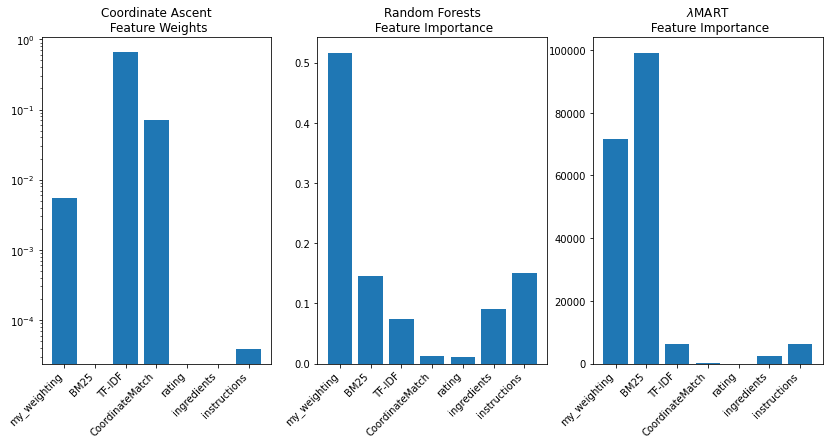

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()